# IsBit Research and Testing Notebook

## Initial Plan

The initial plan is to split the data set of 5451 question text data into three separate subsets.
The formatting of each data set is described below. The first set contains 80% of the parent data and is reserved for local training of different
clustering models. The remaining 20% are further divided into two unseen test sets of 10% each, one for remote testing exported to the application and another for local evaluation of models(hence containing the coarse-label).

`ML/data/QAQC_v1/swe_local_train.csv`: 

 This is the data source that is preprocessed and split into three subsets.

`ML/data/QAQC_v1/splits/local_train.csv `:

This is the first subset, where data rows are formatted as `Hur utvecklades träldomen i Ryssland?`. These are the questions used for training the local clustering models.

`ML/data/QAQC_v1/splits/local_test.csv`: 

This is the second subset formatted as `Hur utvecklades träldomen i Ryssland?, DESC`. These are questions with additional coarse labels used for local evaluation of the different clustering models.

`ML/data/QAQC_v1/splits/remote_test.csv` :

This is the third subset with the same formatting as the second one. These questions are meant to be used for user-tests exported to the application.

---

## QAQC Preprocessing

The following section will preprocess and split the source data into the three mentioned data slices, keep in mind that all data file names are in the .gitignore to avoid pushing data files to origin, download the source data set to the following path `ML/data/QAQC_v1` and run the preprocessing section to slice the data for training and testing. The souce data can be found at `https://spraakbanken.gu.se/en/resources/sveat` 

If further preprocessing is needed I suggest saving it under `ML/data/QAQC_v2/` and inserting the created file names into .gitignore.

The cells below will filter the source data and create new formatted csv files with the following changes in format compared to the source data,

- Removing commas inside the text field replacing then with pipe signs | .
- Removing outer quotations marks of the textfield.
- Insert escape chars where needed, mostly text fields containing quotes. 

Examples of both raw and processed data files with some normal and edge cases in the data rows can be found under `ML/data_exampels`

In [ ]:

# run
# pip install -r ML/requirements.txt

# or run these pip intall 
# > pip install scikit-learn
# > pip install -U sentence-transformers
# > pip install seaborn

# or uncomment lines below and run this cell.
#'%pip install scikit-learn'
#'%pip install sentence-transformers'
#'%pip install seaborn'

Downloads the source data.

In [ ]:
import os
import requests

exists = os.path.isfile(os.path.join("./data/QAQC_v1", "swe_qaqc_train.csv"))
if exists:
    print("File exists")
else:
    dataset = "https://svn.spraakbanken.gu.se/sb-arkiv/pub/trec/swe_qaqc_train.csv"
    response = requests.get(dataset)
    open("./data/QAQC_v1/swe_qaqc_train.csv", "wb").write(response.content)
    print("File downloaded")

Removing of commas and quotations marks.

In [2]:
import pandas as pd
import csv
import re
import os

source_path = "data/QAQC_v1/swe_qaqc_train.csv"        # path to the source data, need to be downloaded ignored for git
output_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"   # set the same output path to not push data to git

# helper to remove outer quotation marks
def strip_outer_quotationmarks(q):
    if q.startswith('"') and q.endswith('"'):
        q = q[1:-1]  
    return q.strip()

# helper to remove commas in the question text, causes problems since the cols are set by commas in csv file
def replace_commas(line):
    pattern = r'"([^"]*?)"'
    def replace_commas(match):
        return '"' + match.group(1).replace(',', '|') + '"'
    return re.sub(pattern, replace_commas, line)

def process_csv(source_data_path, output_data_path, temp_file_path="temp_file.csv"):
    with open(source_data_path, 'r', encoding='utf-8') as infile:
        modified_lines = [replace_commas(line.strip()) for line in infile]

    with open(temp_file_path, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write('\n'.join(modified_lines))

    temp_data = pd.read_csv(temp_file_path, quoting=csv.QUOTE_NONE)  
    questions = temp_data["text"].tolist()
    no_comma_questions = [strip_outer_quotationmarks(q) for q in questions]

    coarse_labels = list(map(lambda x: x.split(":")[0], temp_data["verbose label"].tolist())) # only keep the coarse lable 
    zipped = list(zip(no_comma_questions, coarse_labels))

    with open(output_data_path, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["text", "coarse label"])
        writer.writerows(zipped)

    if os.path.exists(temp_file_path):
        os.remove(temp_file_path)


    #print(f"Processed data saved to {output_data_path}") # trace print

# data formatted and ready for splitting 
_ = process_csv(source_path, output_path)

QAQC data split Version 1

Splits the formatted data into 80% local training data, 10% local test data and 10% remote user test data.

In [ ]:
from sklearn.model_selection import train_test_split

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['coarse label'])
    local_test_data, remote_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True, stratify=test_data['coarse label'])
    
    local_train_data = train_data[['text']].copy()  # no need for the lable that wont be used as a lable
    
    local_test_data_for_eval = local_test_data[['text', 'coarse label']].copy()
    remote_test_data_for_eval = remote_test_data[['text', 'coarse label']].copy()
    
    local_train_file = os.path.join(split_path, "local_train.csv")
    local_test_file = os.path.join(split_path, "local_test.csv")
    remote_test_file = os.path.join(split_path, "remote_test.csv")
    
    local_train_data.to_csv(local_train_file, index=False, header=True)
    local_test_data_for_eval.to_csv(local_test_file, index=False, header=True)
    remote_test_data_for_eval.to_csv(remote_test_file, index=False, header=True)
    
    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v1/splits/"
data_split(source_path, split_path)


QAQC data split version 2

Splits the formatted data into 90% training data and 10% for late stage validation.

Creates two copies of the 90% sized set, one without the coarse label and one with the coarse label. The data set **without** the coarse label should be used when creating data points to be sent forward in the application pipe. 

In [ ]:
from sklearn.model_selection import train_test_split

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, shuffle=True, stratify=data['coarse label'])
    
    train_data_nl = train_data[['text']].copy()
    train_data_wl = train_data[['text', 'coarse label']].copy()  
    test_data = test_data [['text', 'coarse label']].copy()
    
    train_nl_file = os.path.join(split_path, "train_nl_data.csv")
    train_wl_file = os.path.join(split_path, "train_wl_data.csv")
    test_file  = os.path.join(split_path, "test_data.csv")
    
    train_data_nl.to_csv(train_nl_file, index=False, header=True)
    train_data_wl.to_csv(train_wl_file, index=False, header=True)
    test_data.to_csv(test_file, index=False, header=True)

    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v2/splits/"
data_split(source_path, split_path)

---
# SentenceTransformers

Testing pre trained model referenced on official page of SentenceTransformer

C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


             x         y
0    -0.274493 -0.478551
1    -0.894416  0.519476
2     2.554361  0.095175
3     1.699717 -0.270005
4     0.193263  0.235481
...        ...       ...
4900  1.563628 -0.504281
4901 -0.216635  0.441563
4902  0.463843 -0.416398
4903 -1.140864 -0.768737
4904 -2.231941 -2.950688

[4905 rows x 2 columns]


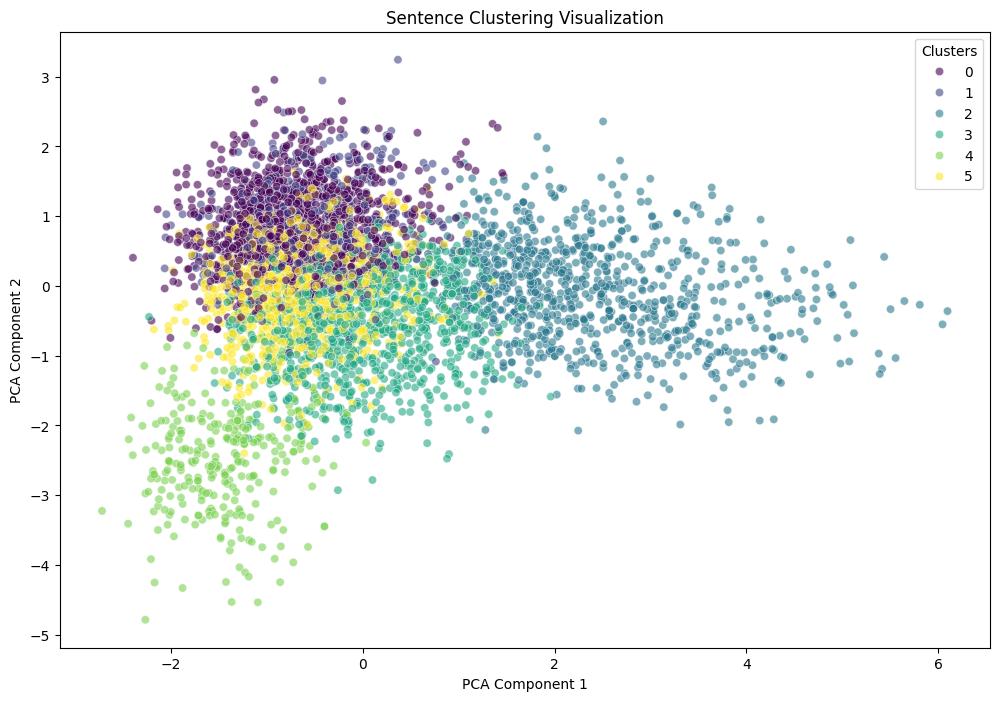

In [1]:

from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


train_data_path = 'data/QAQC_v2/splits/train_data.csv'
data = pd.read_csv(train_data_path)
sentences = data['text'].tolist() 

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, convert_to_tensor=True)
num_clusters = 6 # coarse lables: [LOC, HUM, DESC, ENTY, ABBR, NUM] 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings.cpu().numpy())
clusters = kmeans.labels_

# reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings.cpu().numpy())

# frame
cluster_df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])

print(cluster_df)

cluster_df['cluster'] = clusters

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6)
plt.title('Sentence Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Clusters')
plt.show()
